In [115]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from scipy import stats

import tensorflow


In [3]:
K.set_learning_phase(0)
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

# Find best average model

### gen CAV

In [116]:
concepts = [class_1,class_2]
bottleneck = layer
hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)
cav_dir = working_dir + '/cav_dir'
target_class = 'zebra'
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
cav_data = cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir=cav_dir)
this_cav = cav_data.cavs[0]

In [31]:
cav_name

'striped_sub_1-random500_0-mixed9-linear-0.1'

### Load CAV

In [106]:
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name 

# Load training/testing data
path = os.path.join(working_dir,sub_path + '_test.pkl')
with open(path, 'rb') as f:
    data = pickle.load(f)
    
d = dict(data)
x_train = d['x_train']
x_test = d['x_test']
y_train = d['y_train']
y_test = d['y_test']
y_pred = d['y_pred']

path = os.path.join(working_dir,sub_path + '.pkl')

with open(path, 'rb') as f:
    cav_data = pickle.load(f)
original_CAV_from_data = cav_data['cavs'][0]
original_CAV = original_CAV_from_data



In [57]:
models_dict = {}

In [47]:
#this_cav.shape

In [13]:
lm = linear_model.SGDClassifier(alpha=.1)
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

In [52]:
## get original CAV
#lm.fit(x_train,y_train)
#original_CAV = -lm.coef_[0]
original_CAV = original_CAV_from_data

cavs = []

## remove one point
for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)
        
        new_lm = linear_model.SGDClassifier(alpha=.1)
        new_lm.fit(x_train_new,y_train_new)
        cav_params = -new_lm.coef_[0]
        sim = euclidean_distance(vec_norm(cav_params),vec_norm(original_CAV))
        cosine_sim = cosine_similarity(cav_params,original_CAV)
        cavs.append([idx,cav_params,sim,cosine_sim,x_point])
        
cavs_sims = np.array([a[2] for a in cavs])
cos_sims = np.array([a[3] for a in cavs]) 

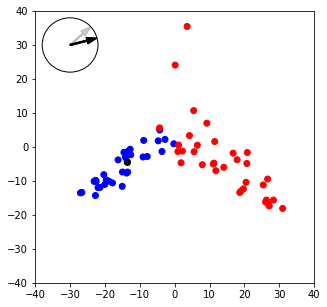

In [178]:
## Plot new
idx = 1
this_cav = cavs[idx][1]
x_point = cavs[idx][0]
x_train_new = np.delete(x_train, x_point, axis=0)
x_rem = x_train[x_point]
y_train_new = np.delete(y_train, x_point, axis=0)

x_train_embed_pca = np.dot(pca_components, x_train_new.T)
color_train_pca = ['red' if y == 0 else 'blue' for y in y_train_new]

b = np.dot(pca_components, x_rem.T)
#a = np.delete(x_train_embed_pca, x_point, axis=1)

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])
plt.scatter(x_train_embed_pca[0], x_train_embed_pca[1], color = color_train_pca)

plt.scatter(b[0], b[1], color = 'black')

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [-30,30]

# new cav is dark
cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vec_norm(cav_pca) * 8
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a0 = ax.add_patch(my_arrow)

# orig is transparent
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * 8
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .1)
a1 = ax.add_patch(my_arrow_1)



In [107]:
x = d['x']
y = d['y']

In [137]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state = 11)

In [138]:
x_train.shape

(67, 131072)

In [145]:
## Find TCAV score

In [228]:
class_acts = acts[target_class][bottleneck]

In [298]:
models_dict['n_10_30'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 30

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_30'].append([-lm.coef_,accuracy])

In [299]:
for coef,acc in models_dict['n_10_30']:
    d = round(euclidean_distance(coef,original_CAV),2)
    
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.15 1.0 0.74
5.02 1.0 0.78
5.14 1.0 0.62
4.9 1.0 0.66
5.29 1.0 0.64
5.2 1.0 0.62
5.25 1.0 0.64
5.06 1.0 0.68
5.06 1.0 0.82
5.14 1.0 0.62


In [300]:
comp_tcav(target_class,original_CAV,class_acts,bottleneck)

1.0

In [296]:
## split = 0
models_dict['no_test'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, stratify=y)
        x_train, y_train = x, y
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    #accuracy = metrics.accuracy_score(y_pred, y_test)
    accuracy = None
    models_dict['no_test'].append([-lm.coef_,accuracy])

In [297]:
for coef,acc in models_dict['no_test']:
    d = round(euclidean_distance(coef,original_CAV),2)
    
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.78 None 0.82
5.51 None 0.52
6.56 None 0.08
5.26 None 0.38
6.19 None 0.58
6.21 None 0.86
5.83 None 0.94
6.03 None 0.68
5.75 None 0.98
5.34 None 0.68


In [301]:
models_dict['n_10_1'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_1'].append([-lm.coef_,accuracy])

In [302]:
for coef,acc in models_dict['n_10_1']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

5.93 0.9696969696969697 0.88
7.33 1.0 0.16
6.4 1.0 0.7
6.6 1.0 0.66
6.13 0.9696969696969697 0.76
6.35 0.8787878787878788 0.84
6.33 1.0 0.8
7.72 0.9090909090909091 0.34
6.25 1.0 0.9
6.98 1.0 0.26


In [310]:
models_dict['n_10_1_seed'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state = 1)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    models_dict['n_10_1_seed'].append([-lm.coef_,accuracy])

In [311]:
for coef,acc in models_dict['n_10_1_seed']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

6.95 0.9696969696969697 0.84
6.62 0.9696969696969697 0.56
6.86 0.9696969696969697 0.66
6.37 0.9696969696969697 0.74
6.03 0.9393939393939394 0.96
6.4 0.9696969696969697 0.58
6.69 1.0 0.22
6.13 0.9696969696969697 0.66
6.14 0.9696969696969697 0.52
6.5 0.9696969696969697 0.66


In [303]:
## center of mass for CAV
models_dict['center_of_mass'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        
        p_avg = x_train_p.mean(axis=0,keepdims=True)
        n_avg = x_train_n.mean(axis=0,keepdims=True)
        
        cav_by_mass = -(p_avg - n_avg).reshape(-1)
        #x_train, y_train = x, y
        #lm.fit(x_train,y_train)
        these_c[j] = cav_by_mass
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    #y_pred = lm.predict(x_test)
    #accuracy = metrics.accuracy_score(y_pred, y_test)
    accuracy = None
    models_dict['center_of_mass'].append([-lm.coef_,accuracy])

In [304]:
for coef,acc in models_dict['center_of_mass']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

35.06 None 0.68
34.61 None 0.5
35.36 None 0.52
35.56 None 0.66
33.36 None 0.58
36.46 None 0.56
34.71 None 0.56
34.97 None 0.62
35.81 None 0.64
34.72 None 0.54


In [322]:
models_dict.keys()

dict_keys(['no_test', 'n_10_30', 'n_10_1', 'center_of_mass', 'n_10_1_seed'])

In [323]:
list_of_cavs = models_dict['n_10_1']
#list_of_cavs = models_dict['n_10_1_seed']

list_of_cavs = models_dict['n_10_30']
#list_of_cavs = models_dict['no_test']
#list_of_cavs = models_dict['center_of_mass']

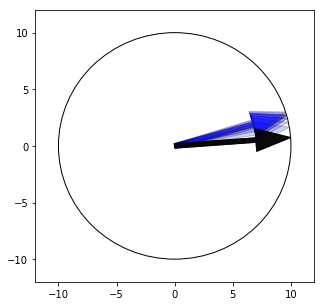

In [327]:
## Plot CAVs in loop
list_of_cavs = models_dict['n_10_30']

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav,acc in list_of_cavs:
    cav_pca = np.dot(pca_components, this_cav.reshape(-1).T)
    cav_norm = vec_norm(cav_pca) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .1)
    a0 = ax.add_patch(my_arrow)

# orig is dark
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * radius
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a1 = ax.add_patch(my_arrow_1)

In [ ]:
acts_orig_array = np.zeros((len(img_paths),131072))
acts_new_array = np.zeros((len(img_paths),131072))

for i,img_path in enumerate(img_paths):
    img = prep(img_path)
    
    acts_orig = get_acts(img)
    acts_orig_array[i] = acts_orig

    #acts_final_raw = gradient_ascent_using_acts(acts_orig.reshape(1,8,8,2048),iterations=iterations,step=step,max_loss=max_loss)
    #acts_final = acts_final_raw.reshape(-1)
    #acts_new_array[i] = acts_final

    img, acts_list = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
    acts_new_array[i] = get_acts(img)

## Peak to Peak

In [12]:
concept = 'striped_sub_1'

concept_dir = os.path.join(working_dir,'concepts/'+concept)
concept_image_list = files_from_dir_ext(concept_dir,'jpg')
concept_image_list.sort()

n = 131072
activations = np.zeros((len(concept_image_list),n))
for idx,image_path in enumerate(concept_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    activations[idx] = acts_orig

concept = 'random500_0'
concept_dir = os.path.join(working_dir,'concepts/'+concept)
random_image_list = files_from_dir_ext(concept_dir,'JPEG')
random_image_list.sort()

n = 131072
acts_ran = np.zeros((len(random_image_list),n))
for idx,image_path in enumerate(random_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    acts_ran[idx] = acts_orig

In [13]:
#random_image_list

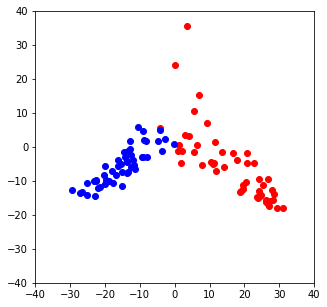

In [14]:
light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# concept
embed_pca_con = np.dot(pca_components, activations.T)
plt.scatter(embed_pca_con[0], embed_pca_con[1], color = 'r')

# random
embed_pca_ran = np.dot(pca_components, acts_ran.T)
plt.scatter(embed_pca_ran[0], embed_pca_ran[1], color = 'b')

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

In [15]:
embed_pca_con.shape

(2, 50)

In [16]:
gm_con = GaussianMixture(n_components=1)
gm_ran = GaussianMixture(n_components=1)

gm_con.fit(embed_pca_con.T)
gm_ran.fit(embed_pca_ran.T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

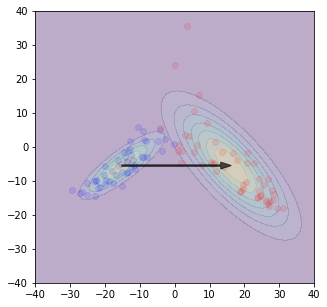

In [101]:
from matplotlib import cm

fig = plt.figure(figsize=[5,5])

N = 60
X = np.linspace(-40, 40, N)
Y = np.linspace(-40, 40, N)
X, Y = np.meshgrid(X, Y)

mu_1 = np.mean(embed_pca_con.T, axis=0)
Sigma_1 = np.cov(embed_pca_con.T, rowvar=0)

mu_2 = np.mean(embed_pca_ran.T, axis=0)
Sigma_2 = np.cov(embed_pca_ran.T, rowvar=0)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

F1 = multivariate_normal(mu_1, Sigma_1)
Z1 = F1.pdf(pos)

F2 = multivariate_normal(mu_2, Sigma_2)
Z2 = F2.pdf(pos)

ax = fig.gca()

cset = ax.contourf(X, Y, Z1, cmap=cm.viridis, alpha = .2)
cset = ax.contourf(X, Y, Z2, cmap=cm.viridis, alpha = .2)

plt.scatter(embed_pca_ran[0], embed_pca_ran[1], color = 'b', alpha = .1)
plt.scatter(embed_pca_con[0], embed_pca_con[1], color = 'r', alpha = .1)


cav = mu_1 - mu_2
arrow_start = mu_2
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
#a1 = ax.add_patch(my_arrow)


MU_1 = np.mean(activations, axis=0)
MU_2 = np.mean(acts_ran, axis=0)

MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

cav = MU_1_pca - MU_2_pca

arrow_start = MU_2_pca
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
#a1 = ax.add_patch(my_arrow)


L1_p = np.linalg.norm(activations.T,1,axis = 1) / activations.shape[0]
L1_n = np.linalg.norm(acts_ran.T,1,axis = 1) / acts_ran.shape[0]
L1_cav = L1_p - L1_n

arrow_start = np.dot(pca_components, L1_n)
cav = np.dot(pca_components, L1_cav.reshape(-1).T)
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav[0], cav[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .4)
a1 = ax.add_patch(my_arrow)

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

plt.show()

In [51]:
activations.mean()

MU_1 = np.mean(activations, axis=0)
MU_2 = np.mean(acts_ran, axis=0)

real_cav = MU_1 - MU_2

MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

In [52]:
cav_pca = np.dot(pca_components, real_cav.reshape(-1).T)
cav_norm = vec_norm(cav_pca)

In [53]:
cav_pca

array([3.13590103e+01, 3.50234488e-03])

In [42]:
MU_1_pca = np.dot(pca_components, MU_1.reshape(-1).T)
MU_2_pca = np.dot(pca_components, MU_2.reshape(-1).T)

In [33]:
#real_cav.shape

In [20]:
gm_con = GaussianMixture(n_components=1)
gm_ran = GaussianMixture(n_components=1)

#gm_con.fit(activations)
gm_ran.fit(embed_pca_ran.T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
embed_pca_ran.shape

(2, 50)

# L1

In [66]:
a = np.array([[5,6,7,8],
            [1,2,3,4]])

In [100]:
np.linalg.norm(a,1,axis = 1) / a.shape[1]

array([6.5, 2.5])

In [76]:
a.shape

(2, 4)

In [102]:
## Find CAV


In [121]:
def get_L1(act_for_L1):
    return np.linalg.norm(act_for_L1.T,1,axis = 1) / act_for_L1.shape[1]

In [84]:
L1_p = np.linalg.norm(activations.T,1,axis = 1) / a.shape[1]
L1_n = np.linalg.norm(acts_ran.T,1,axis = 1) / a.shape[1]
L1_cav = L1_p - L1_n

In [104]:
models_dict = {}

In [130]:
models_dict['L1_10'] = []
lm = linear_model.SGDClassifier(alpha=.1)

num_model = 10
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        these_c[j] = get_L1(x_train_p) - get_L1(x_train_n)
        
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    accuracy = None
    models_dict['L1_10'].append([lm.coef_,accuracy])

In [131]:
target_class
for coef,acc in models_dict['L1_10']:
    d = round(euclidean_distance(coef,original_CAV),2)
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    print(d,acc,score)

6.01 None 0.68
6.01 None 0.54
6.01 None 0.68
6.01 None 0.76
6.01 None 0.46
6.01 None 0.64
6.01 None 0.74
6.01 None 0.56
6.01 None 0.6
6.01 None 0.68


In [118]:
concepts = [class_1,class_2]
bottleneck = layer
hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)
cav_dir = working_dir + '/cav_dir'
target_class = 'zebra'
acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
class_acts = acts[target_class][bottleneck]

In [134]:
models_dict.keys()

dict_keys(['n_10_1_seed', 'L1_10'])

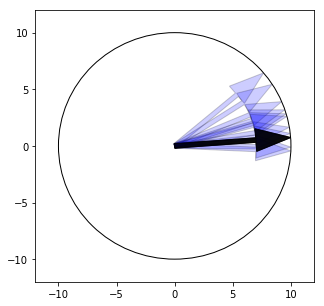

In [137]:
## Plot CAVs in loop
list_of_cavs = models_dict['n_10_1_seed']

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav,acc in list_of_cavs:
    cav_pca = np.dot(pca_components, this_cav.reshape(-1).T)
    cav_norm = vec_norm(cav_pca) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .1)
    a0 = ax.add_patch(my_arrow)

# orig is dark
cav_pca_1 = np.dot(pca_components, original_CAV.T)
cav_norm_1 = vec_norm(cav_pca_1) * radius
my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], cav_norm_1[0], cav_norm_1[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None, alpha = .8)
a1 = ax.add_patch(my_arrow_1)

## Test L1 on Mixed9

In [138]:
concept = 'striped_sub_1'

concept_dir = os.path.join(working_dir,'concepts/'+concept)
concept_image_list = files_from_dir_ext(concept_dir,'jpg')
concept_image_list.sort()

n = 131072
activations = np.zeros((len(concept_image_list),n))
for idx,image_path in enumerate(concept_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    activations[idx] = acts_orig

concept = 'random500_0'
concept_dir = os.path.join(working_dir,'concepts/'+concept)
random_image_list = files_from_dir_ext(concept_dir,'JPEG')
random_image_list.sort()

n = 131072
acts_ran = np.zeros((len(random_image_list),n))
for idx,image_path in enumerate(random_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    acts_ran[idx] = acts_orig
    
## save acts

In [140]:
acts_ran.shape

(50, 131072)

In [154]:
x = np.concatenate((activations,acts_ran))
y = np.concatenate((np.zeros(50),np.ones(50)))

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

In [157]:
#model_test = {}
results = {}

In [170]:
model_test['L1'] = []
model_test['std'] = []

lm = linear_model.SGDClassifier(alpha=.1)

num_model = 100
num_runs = 1

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        
        x_train_p_list,x_train_n_list = [],[]
        for idx,a in enumerate(x_train):
            if y_train[idx] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)
        x_train_p,x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
        these_c[j] = get_L1(x_train_p) - get_L1(x_train_n)
        
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    accuracy = None
    model_test['L1'].append([lm.coef_,accuracy])

for i in range(num_model):
    these_c = np.zeros((num_runs,131072))
    for j in range(num_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
        lm.fit(x_train,y_train)
        these_c[j] = lm.coef_
    lm.coef_ = np.expand_dims(these_c.mean(axis = 0),axis = 0)
    y_pred = lm.predict(x_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    model_test['std'].append([-lm.coef_,accuracy])

In [171]:
results['L1'] = []
for coef,acc in model_test['L1']:
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    results['L1'].append(score)

results['std'] = []
for coef,acc in model_test['std']:
    score = comp_tcav(target_class,coef.reshape(-1),class_acts,bottleneck)
    results['std'].append(score)

In [172]:
np.array(results['L1']).mean(),np.array(results['L1']).var()

(0.5972000000000001, 0.011088159999999998)

In [173]:
np.array(results['std']).mean(),np.array(results['std']).var()

(0.616, 0.06337599999999999)

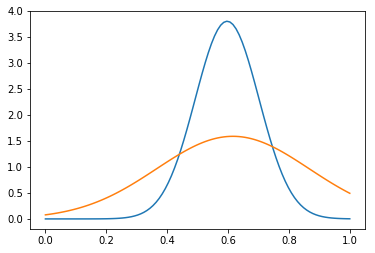

In [180]:
mu = .597
variance = .011
sigma = math.sqrt(variance)
x = np.linspace(0,1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

mu = .616
variance = .063
sigma = math.sqrt(variance)
x = np.linspace(0,1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.show()

In [178]:
#results['std']

## Recover Hyperplane

In [290]:
c1 = model_test['std'][1][0]
c2 = model_test['L1'][1][0]

In [291]:
c2.shape

(1, 131072)

In [292]:
lm.coef_ = -c2
lm.intercept_ = np.array([0])
#lm.coef_ = -c1

In [298]:
np.dot(lm.coef_,x_test[0])

array([-0.19500707])

In [293]:
y_pred = lm.predict(x_test)
accuracy = metrics.accuracy_score(y_pred, y_test)
print(accuracy)

1.0


In [294]:
lm.decision_function(x_test)

array([-0.19500707, -0.12821534, -0.25378711, -0.25886894,  0.00983741,
       -0.02909258, -0.20908766, -0.23388604,  0.11092905,  0.24280813,
        0.21533899, -0.24325414, -0.09137111, -0.13284176, -0.24964479,
        0.15732819, -0.08463953,  0.18991081,  0.19528924, -0.02891493,
        0.26921717,  0.15779016,  0.11785557, -0.19380926,  0.19532396,
        0.16532376,  0.08595873, -0.03514877,  0.13964887,  0.24997353,
        0.20864605, -0.12107742, -0.21411183])

In [295]:
lm.intercept_

array([0])

## Toy Example

In [377]:
mu_1 = np.array([-2,-2])
sigma_1 = np.array([[3,2],[2,3]])

mu_2 = np.array([2,2])
sigma_2 = np.array([[3,-2],[-2,3]])

In [385]:
n = 50
g1 = multivariate_normal(mu_1, sigma_1)
z1 = g1.rvs(n)
g2 = multivariate_normal(mu_2, sigma_2)
z2 = g2.rvs(n)

In [422]:
x = np.concatenate((z1,z2))
y = np.concatenate((np.zeros(n),np.ones(n)))
lm = linear_model.SGDClassifier(alpha=.1)
lm.fit(x,y)
this_cav = lm.coef_[0]

In [423]:
this_cav

array([0.58144212, 0.76711404])

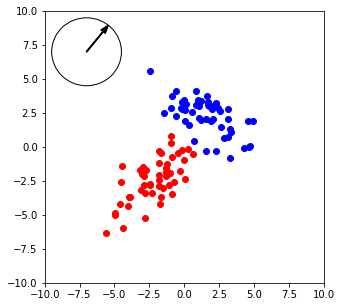

In [421]:
light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# class 1
plt.scatter(z1[:,0], z1[:,1], color = 'r')

# class 2
plt.scatter(z2[:,0], z2[:,1], color = 'b')

ax = plt.gca()
radius = 2.5
circ = plt.Circle((-7,7), radius=radius, edgecolor='black', facecolor='None')
ax.add_patch(circ)

arrow_start = [-7,7]
cav_norm = vec_norm(this_cav) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.05,
                         length_includes_head=True,head_width=.4,fc='k', ec=None, alpha = 1)
a0 = ax.add_patch(my_arrow)

my_xlim = plt.xlim([-10,10])
my_ylim = plt.ylim([-10,10])

In [430]:
## lots of CAVs
this_list = []
for i in range(50):
    n = 50
    g1 = multivariate_normal(mu_1, sigma_1)
    z1 = g1.rvs(n)
    g2 = multivariate_normal(mu_2, sigma_2)
    z2 = g2.rvs(n)

    x = np.concatenate((z1,z2))
    y = np.concatenate((np.zeros(n),np.ones(n)))
    lm = linear_model.SGDClassifier(alpha=.1)
    lm.fit(x,y)
    this_cav = lm.coef_[0]
    this_list.append(this_cav)

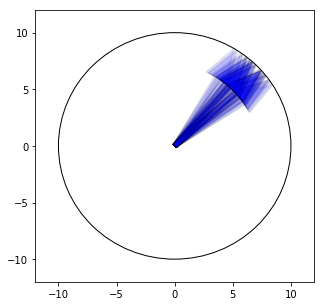

In [431]:
## Plot CAVs in loop
list_of_cavs = this_list

fig = plt.figure(figsize=[5,5])
xlim = plt.xlim([-12,12])
ylim = plt.ylim([-12,12])

radius = 10
circ = plt.Circle((0,0), radius=radius, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)
arrow_start = [0,0]

# new cav is transparent, blue
for this_cav in list_of_cavs:
    cav_norm = vec_norm(this_cav) * radius
    my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                         length_includes_head=True,head_width=2,fc='b', ec=None, alpha = .05)
    a0 = ax.add_patch(my_arrow)


In [297]:
#explained_variance_ratio_

In [7]:
def comp_tcav(target_class,cav,class_acts,bottleneck_name):
    count = 0
    class_id = mymodel.label_to_id(target_class)

    for i in range(len(class_acts)):
        act = np.expand_dims(class_acts[i], 0)
        if get_dir(act, class_id,cav,bottleneck_name):
            count += 1
    return float(count) / float(len(class_acts))

def get_dir(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod < 0

In [11]:
## define functions
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))


def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e]
    return this_ext

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img
    
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'

these_acts = layer_dict[layer_name].output
get_acts_func = K.function([model.input],[these_acts])

def get_acts(input_img):
    outs = get_acts_func([input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)